<a href="https://colab.research.google.com/github/marp98/mlops-foundations/blob/main/MLOps_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

# Extract projects 
PROJECTS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(PROJECTS_URL)
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [121]:
# Extract tags 
TAGS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags = pd.read_csv(TAGS_URL)
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [122]:
# Join projects and tags --> basic transformations to create labeled dataset
df = pd.merge(projects, tags, on="id")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [123]:
df = df[df.tag.notnull()] # remove projects with no tag

# Save locally
df.to_csv("labeled_projects.csv", index=False)

from google.colab import files
files.download("labeled_projects.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

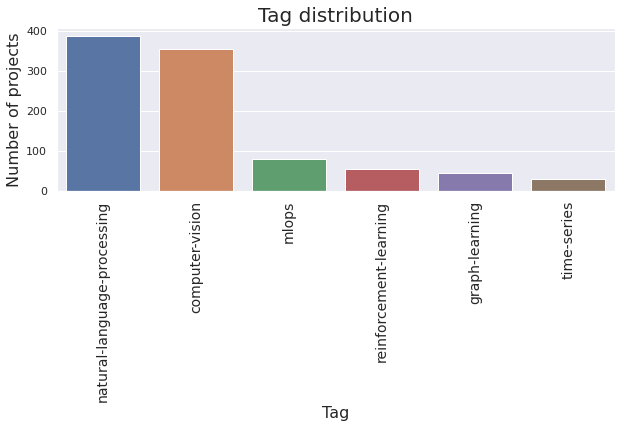

In [124]:
# Distribution of tags (EDA)
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [125]:
# Most common tags 
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

In [126]:
# Most frequent tokens for each tag in title
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing"):
  # Plot word clouds top top tags
  plt.figure(figsize=(15, 5))
  subset = df[df.tag==tag]
  text = subset.title.values
  cloud = WordCloud(
      stopwords=STOPWORDS, background_color="black", collocations=False,
      width=500, height=300).generate(" ".join(text))
  plt.axis("off")
  plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

In [127]:
# Most frequent tokens for each tag in description
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing"):
  # Plot word clouds top top tags
  plt.figure(figsize=(15, 5))
  subset = df[df.tag==tag]
  text = subset.description.values
  cloud = WordCloud(
      stopwords=STOPWORDS, background_color="black", collocations=False,
      width=500, height=300).generate(" ".join(text))
  plt.axis("off")
  plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

In [128]:
# Input
df["text"] = df.title + " " + df.description

In [129]:
!pip install nltk==3.7 -q

In [130]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [131]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower:
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [133]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [134]:
import json

In [135]:
# Accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

In [136]:
# Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [137]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,curriculum reinforcement learning curriculum l...


In [138]:
# Replace this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,curriculum reinforcement learning curriculum l...


In [139]:
# Minimum frequency required for a tag
min_freq = 75
tags = Counter(df.tag.values)

In [140]:
# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=388), Output()), _dom_classes=('widget-i…

In [141]:
def filter(tag, include=[]):
    """Determine if a given tag is to be included."""
    if tag not in include:
        tag = None
    return tag

In [142]:
# Filter tags that have fewer than <min_freq> occurrences
tags_above_freq = Counter(tag for tag in tags.elements() if (tags[tag] >= min_freq))
df.tag = df.tag.apply(filter, include=list(tags_above_freq.keys()))

In [143]:
# Fill None with other
df.tag = df.tag.fillna("other")

In [144]:
import numpy as np
import random

In [145]:
# Get data
X = df.text.to_numpy()
y = df.tag

In [146]:
class LabelEncoder(object):
    """Encode labels into unique indices"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [147]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [148]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [149]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [150]:
# Encode 
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [151]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))

['computer-vision', 'mlops', 'mlops']

In [152]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [153]:
from sklearn.model_selection import train_test_split

In [154]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [155]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

In [156]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [157]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

In [158]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [159]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

In [160]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [161]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [162]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


In [163]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

In [164]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,illustrated fixmatch semi supervised learning ...,computer-vision
1,jiant software toolkit research general purpos...,natural-language-processing
2,illustrated gpt 2 visualizing transformer lang...,natural-language-processing
3,mention classifier category prediction model r...,natural-language-processing
4,training batch norm batch norm experiments ide...,computer-vision


In [165]:
!pip install scikit-learn==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
snorkel 0.9.8 requires scikit-learn<0.25.0,>=0.20.2, but you have scikit-learn 1.0 which is incompatible.


In [166]:
!pip install numpy==1.21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.21.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.6.0 which is incompatible.
snorkel 0.9.8 requires numpy<1.20.0,>=1.16.5, but you have numpy 1.21.0 which is incompatible.
snorkel 0.9.8 requires scikit-learn<0.25.0,>=0.20.2, but you have scikit-learn 1.0 which is incompatible.


In [167]:
!pip install nlpaug==1.1.0 transformers==3.0.2 -q

In [168]:
import nlpaug.augmenter.word as naw

In [169]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")
text = "Conditional image generation using Variational Autoencoders and GANs."

In [170]:
# Substitutions
substitution.augment(text)

'dynamic regression reconstruction using variational algorithms and gans.'

In [171]:
# Insertions
insertion.augment(text)

'supports conditional adaptive image generation functions using dynamic variational autoencoders and gans.'

In [172]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

In [173]:
# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

In [174]:
# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

In [175]:
print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [176]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [177]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [178]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [179]:
!pip install snorkel==0.9.8 -q 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.6.0 which is incompatible.
jax 0.3.17 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
cmdstanpy 1.0.7 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.


In [180]:
from snorkel.augmentation import transformation_function

In [181]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [182]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning natural language processing tasks


In [183]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate vision apply jobs using nlp
autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc


In [184]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [185]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:03<00:00, 197.63it/s]


,text,tag
0,illustrated fixmatch semi supervised learning ...,computer-vision
1,jiant software toolkit research general purpos...,natural-language-processing
2,illustrated gpt 2 visualizing transformer lang...,natural-language-processing
3,mention classifier category prediction model r...,natural-language-processing
4,training batch norm batch norm experiments ide...,computer-vision


In [186]:
len(train_df), len(train_df_augmented)

(668, 914)

In [187]:
import random

In [188]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)

In [189]:
def preprocess(df, lower, stem, min_freq):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df.text = df.text.apply(clean_text, lower=lower, stem=stem)  # clean text

    # Replace OOS tags with `other`
    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags_above_freq = Counter(tag for tag in tags.elements()
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df

In [190]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [191]:
df = df.sample(frac=1).reset_index(drop=True)  # shuffle
df = df[: 5]  # None = all samples

In [192]:
from sklearn.metrics import precision_recall_fscore_support

In [193]:
# Set up
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [194]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [195]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print (y_pred.shape)
print (y_pred[0:5])

(144,)
[2 2 1 3 3]


In [196]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.2844744487889649,
  "recall": 0.22916666666666666,
  "f1": 0.24552884283001275
}


In [197]:
# Class frequencies
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
p

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]

In [198]:
# Generate weighted random predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

In [199]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.3294211281499417,
  "recall": 0.3194444444444444,
  "f1": 0.3239553132352485
}


In [200]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [201]:
def get_tag(text, aliases_by_tag):
    """If a token matches an alias,
    then add the corresponding tag class."""
    for tag, aliases in aliases_by_tag.items():
        if replace_dash(tag) in text:
            return tag
        for alias in aliases:
            if alias in text:
                return tag
    return None

In [202]:
# Sample
text = "A pretrained model hub for popular nlp models."
get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag)

'natural-language-processing'

In [203]:
# Prediction
tags = []
for text in X_test:
    tag = get_tag(text, aliases_by_tag=aliases_by_tag)
    tags.append(tag)

In [204]:
# Encode labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]

In [205]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8611111111111112,
  "recall": 0.1597222222222222,
  "f1": 0.2600750175139683
}


In [206]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag))

None


In [207]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [208]:
def preprocess(df, lower, stem, min_freq):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df.text = df.text.apply(clean_text, lower=lower, stem=stem)  # clean text

    # Replace OOS tags with `other`
    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags_above_freq = Counter(tag for tag in tags.elements()
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df

In [211]:
# Saving raw X_test to compare with later
X_test_raw = X_test

In [212]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train.shape)  # scipy.sparse.csr_matrix

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
(668, 98496)


In [213]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [249  55 272  92],
class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


In [217]:
!pip install imbalanced-learn==0.8.1 -q

In [218]:
from imblearn.over_sampling import RandomOverSampler

In [219]:
# Oversample (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [220]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


Model - Logistic Regression with SGD

In [221]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [222]:
# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="constant", eta0=1e-1, power_t=0.1,
    warm_start=True)

In [223]:
# Train model
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.fit(X_over, y_over)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

Epoch: 00 | train_loss: 1.16881, val_loss: 1.20216
Epoch: 10 | train_loss: 0.46161, val_loss: 0.62198
Epoch: 20 | train_loss: 0.31540, val_loss: 0.51541
Epoch: 30 | train_loss: 0.25148, val_loss: 0.47084
Epoch: 40 | train_loss: 0.21651, val_loss: 0.44734
Epoch: 50 | train_loss: 0.19547, val_loss: 0.43314
Epoch: 60 | train_loss: 0.18170, val_loss: 0.42407
Epoch: 70 | train_loss: 0.17241, val_loss: 0.41808
Epoch: 80 | train_loss: 0.16591, val_loss: 0.41399
Epoch: 90 | train_loss: 0.16118, val_loss: 0.41096


In [224]:
# Evaluate
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8764647844565878,
  "recall": 0.875,
  "f1": 0.8737886461377173
}


In [225]:
# Inference (with tokens similar to training data)
text = "Transfer learning with transformers for text classification."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [226]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.031620508668047075,
 'mlops': 0.0035373010810466708,
 'natural-language-processing': 0.9533040304105429,
 'other': 0.011538159840363202}

In [229]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [230]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.1414342524155095,
 'mlops': 0.10863564113169032,
 'natural-language-processing': 0.6606401665967965,
 'other': 0.08928993985600372}

In [231]:
# Determine first quantile softmax score for the correct class (on validation split)
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1
threshold

0.6775387384573037

In [232]:
# Custom predict function
def custom_predict(y_prob, threshold, index):
    """Custom predict function that defaults
    to an index if conditions are not met."""
    y_pred = [np.argmax(p) if max(p) > threshold else index for p in y_prob]
    return np.array(y_pred)

In [233]:
def predict_tag(texts):
    y_prob = model.predict_proba(vectorizer.transform(texts))
    other_index = label_encoder.class_to_index["other"]
    y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)
    return label_encoder.decode(y_pred)

In [234]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
predict_tag(texts=[text])

['other']

In [237]:
# Evaluate
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=label_encoder.class_to_index["other"])
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9107142857142857,
  "recall": 0.75,
  "f1": 0.7874872825628427
}


In [238]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [239]:
# Data to evaluate
other_index = label_encoder.class_to_index["other"]
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)

In [240]:
from sklearn.metrics import precision_recall_fscore_support

In [241]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9107142857142857,
    "recall": 0.75,
    "f1": 0.7874872825628427,
    "num_samples": 144.0
}


In [242]:
from collections import OrderedDict

In [243]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [244]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 1.0,
  "recall": 0.7413793103448276,
  "f1": 0.8514851485148515,
  "num_samples": 58.0
}


In [245]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "mlops",
  {
    "precision": 1.0,
    "recall": 0.75,
    "f1": 0.8571428571428571,
    "num_samples": 12.0
  }
]
[
  "natural-language-processing",
  {
    "precision": 1.0,
    "recall": 0.7413793103448276,
    "f1": 0.8514851485148515,
    "num_samples": 58.0
  }
]
[
  "computer-vision",
  {
    "precision": 1.0,
    "recall": 0.6666666666666666,
    "f1": 0.8,
    "num_samples": 54.0
  }
]
[
  "other",
  {
    "precision": 0.35714285714285715,
    "recall": 1.0,
    "f1": 0.5263157894736842,
    "num_samples": 20.0
  }
]


In [246]:
# TP, FP, FN samples
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [247]:
print (tp)
print (fp)
print (fn)

[0, 5, 47, 52, 96, 111, 123, 129, 141]
[]
[38, 130, 136]


In [248]:
index = tp[0]
print (X_test_raw[index])
print (f"true: {label_encoder.decode([y_test[index]])[0]}")
print (f"pred: {label_encoder.decode([y_pred[index]])[0]}")

pytest pytest framework makes easy write small tests yet scales support complex functional testing
true: mlops
pred: mlops


In [249]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"  {X_test_raw[index]}")
            print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")


=== True positives ===
  pytest pytest framework makes easy write small tests yet scales support complex functional testing
    true: mlops
    pred: mlops

  test machine learning code systems minimal examples testing machine learning correct implementation expected learned behaviour model performance
    true: mlops
    pred: mlops

  continuous machine learning cml cml helps organize mlops infrastructure top traditional software engineering stack instead creating separate ai platforms
    true: mlops
    pred: mlops


=== False negatives ===
  hidden technical debt machine learning systems using software engineering framework technical debt find common incur massive ongoing maintenance costs real world ml systems
    true: mlops
    pred: other

  docker help become effective data scientist look docker perspective data scientist
    true: mlops
    pred: other

  neptune ai lightweight experiment management tool fits workflow
    true: mlops
    pred: other



In [250]:
# y
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

(144,)
(144, 4)


In [251]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

In [252]:
# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

In [253]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i],
                               "true": label_encoder.index_to_class[y_test[i]],
                               "pred": label_encoder.index_to_class[y_pred[i]],
                               "prob": prob})

In [254]:
low_confidence[0:5]

[{'text': 'neptune ai lightweight experiment management tool fits workflow',
  'true': 'mlops',
  'pred': 'other',
  'prob': 0.4290550617208323}]

In [255]:
pip install cleanlab==1.0.1 -q

     |████████████████████████████████| 78 kB 4.0 MB/s 


In [256]:
import cleanlab
from cleanlab.pruning import get_noise_indices

In [257]:
# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test,
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)

In [258]:
num_samples = 5
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

text: module 2 convolutional neural networks cs231n lecture 5 move fully connected neural networks convolutional neural networks
true: computer-vision
pred: other

text: forex prediction using neural networks predict movement forex direction
true: natural-language-processing
pred: other

text: goturn pytorch pytorch implementation learning track 100 fps deep regression networks
true: computer-vision
pred: other



In [259]:
pip install snorkel==0.9.8 -q

In [260]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [261]:
@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)

In [262]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [263]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 5448.47it/s]


,text,tag
110,understanding convolutional neural networks nl...,natural-language-processing


In [264]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 19198.95it/s]


,text,tag
33,chakin simple downloader pre trained word vectors,natural-language-processing
73,tsaug python package time series augmentation,other
76,nlpaug data augmentation nlp,natural-language-processing
79,texthero text preprocessing representation vis...,natural-language-processing
111,machine learning production pipeline project f...,mlops


In [265]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 144/144 [00:00<00:00, 8463.96it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [266]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [267]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_cnn": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 1
  },
  "short_text": {
    "precision": 0.4,
    "recall": 0.4,
    "f1": 0.4000000000000001,
    "num_samples": 5
  }
}


In [268]:
pip install lime==0.2.0.1 -q

     |████████████████████████████████| 275 kB 9.9 MB/s 


In [269]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [270]:
# Create pipeline
pipe = make_pipeline(vectorizer, model)

In [271]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

In [272]:
pip install mlflow==1.23.1 -q

     |████████████████████████████████| 15.6 MB 473 kB/s 
     |████████████████████████████████| 147 kB 49.3 MB/s 
     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 209 kB 39.9 MB/s 
     |████████████████████████████████| 181 kB 49.6 MB/s 
     |████████████████████████████████| 140 kB 47.5 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 


In [273]:
from argparse import Namespace
import mlflow
from pathlib import Path

In [274]:
# Specify arguments
args = Namespace(
    lower=True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100
)

In [275]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))

In [276]:
ls

experiments/  labeled_projects.csv  sample_data/


In [282]:
def train(args, df, trial=None):
    """Train model on data."""

    # Setup
    set_seeds()
    df = pd.read_csv("labeled_projects.csv")
    df = df.sample(frac=1).reset_index(drop=True)
    df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
    label_encoder = LabelEncoder().fit(df.tag)
    X_train, X_val, X_test, y_train, y_val, y_test = \
        get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

    # Tf-idf
    vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=(2,args.ngram_max_range))  # char n-grams
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    # Oversample
    oversample = RandomOverSampler(sampling_strategy="all")
    X_over, y_over = oversample.fit_resample(X_train, y_train)

    # Model
    model = SGDClassifier(
        loss="log", penalty="l2", alpha=args.alpha, max_iter=1,
        learning_rate="constant", eta0=args.learning_rate, power_t=args.power_t, 
        warm_start=True)

    # Training
    for epoch in range(args.num_epochs):
        model.fit(X_over, y_over)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

        # Log
        if not trial:
            mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

        # Pruning (for optimization in next section)
        if trial:
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Threshold
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)
    args.threshold = np.quantile(
        [y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1

    # Evaluation
    other_index = label_encoder.class_to_index["other"]
    y_prob = model.predict_proba(X_test)
    y_pred = custom_predict(y_prob=y_prob, threshold=args.threshold, index=other_index)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print (json.dumps(performance, indent=2))

    return {
        "args": args,
        "label_encoder": label_encoder,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

In [289]:
def preprocess(df, lower, stem, min_freq):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df.text = df.text.apply(clean_text, lower=lower, stem=stem)  # clean text

    # Replace OOS tags with `other`
    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags = Counter(df.tag.values)
    tags_above_freq = Counter(tag for tag in tags.elements() 
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df

In [290]:
import joblib
import tempfile

In [291]:
# Set experiment
mlflow.set_experiment(experiment_name="baselines")

<Experiment: artifact_location='file:///content/experiments/0', experiment_id='0', lifecycle_stage='active', name='baselines', tags={}>

In [292]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

In [293]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

Epoch: 00 | train_loss: 1.16783, val_loss: 1.20177
Epoch: 10 | train_loss: 0.46262, val_loss: 0.62612
Epoch: 20 | train_loss: 0.31599, val_loss: 0.51986
Epoch: 30 | train_loss: 0.25191, val_loss: 0.47544
Epoch: 40 | train_loss: 0.21720, val_loss: 0.45176
Epoch: 50 | train_loss: 0.19610, val_loss: 0.43770
Epoch: 60 | train_loss: 0.18221, val_loss: 0.42857
Epoch: 70 | train_loss: 0.17291, val_loss: 0.42246
Epoch: 80 | train_loss: 0.16643, val_loss: 0.41818
Epoch: 90 | train_loss: 0.16160, val_loss: 0.41528
{
  "precision": 0.9116161616161617,
  "recall": 0.7569444444444444,
  "f1": 0.7929971988795519
}


In [294]:
# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 10.313s
your url is: https://dark-planets-glow-34-125-241-28.loca.lt
^C


In [295]:
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [296]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

                             run_id experiment_id    status  \
0  71537081ae094319952eb72b73114723             0  FINISHED   
1  bc453683a568420bb89f680dff2f1bb7             0    FAILED   
2  52f740fe9fc54a9ab2aa6418451808c3             0    FAILED   
3  eb214b417fc241d29ab87a0d2902ea78             0    FAILED   

                                        artifact_uri  \
0  file:///content/experiments/0/71537081ae094319...   
1  file:///content/experiments/0/bc453683a568420b...   
2  file:///content/experiments/0/52f740fe9fc54a9a...   
3  file:///content/experiments/0/eb214b417fc241d2...   

                        start_time                         end_time  \
0 2022-09-12 13:22:27.620000+00:00 2022-09-12 13:22:34.200000+00:00   
1 2022-09-12 13:21:19.886000+00:00 2022-09-12 13:21:19.960000+00:00   
2 2022-09-12 13:19:15.827000+00:00 2022-09-12 13:19:16.061000+00:00   
3 2022-09-12 13:18:03.545000+00:00 2022-09-12 13:18:03.660000+00:00   

   metrics.f1  metrics.val_loss  metrics.precis

In [297]:
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
    label_encoder = LabelEncoder.load(fp=Path(dp, "label_encoder.json"))
    model = joblib.load(Path(dp, "model.pkl"))
    performance = load_dict(filepath=Path(dp, "performance.json"))

In [298]:
print (json.dumps(performance, indent=2))

{
  "precision": 0.9116161616161617,
  "recall": 0.7569444444444444,
  "f1": 0.7929971988795519
}


In [299]:
# Inference
text = "Transfer learning with transformers for text classification."
predict_tag(texts=[text])

['natural-language-processing']